In [1]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

In [2]:
TRAIN_DIR = 'C:/Users/Sf Nicolae/Desktop/Cat/train'
TEST_DIR = 'C:/Users/Sf Nicolae/Desktop/Cat/test'
IMG_SIZE = 50
LR = 1e-3 

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '4convs-basic')

In [3]:
def label_img(img):
  word_label = img.split('.')[0]
  if word_label == 'cat': return [1,0]
  elif word_label == 'dog': return [0,1]

In [4]:
def create_train_data():
  training_data = []
  for img in tqdm(os.listdir(TRAIN_DIR)):
    label = label_img(img)
    path = os.path.join(TRAIN_DIR, img)
    img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
    training_data.append([np.array(img), np.array(label)])
  shuffle(training_data)
  np.save('train_data.npy', training_data)
  return training_data

In [5]:
def process_test_data():
  testing_data = []
  for img in tqdm(os.listdir(TEST_DIR)):
    path = os.path.join(TEST_DIR, img)
    img_num = img.split('.')[0]
    img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
    testing_data.append([np.array(img), img_num])

  np.save('test_data.npy', testing_data)
  return testing_data

In [ ]:
train_data = create_train_data()

In [ ]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.compat.v1.reset_default_graph()


convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [ ]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded.')

In [9]:
train = train_data[:-500]
test = train_data[-500:]

In [10]:
X = np.array([i[0] for i in train], dtype=np.float32 ).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = np.array([i[1] for i in train], dtype=np.float32 )

test_x = np.array([i[0] for i in test], dtype=np.float32 ).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = np.array([i[1] for i in test], dtype=np.float32 )

In [11]:
model.fit(X ,Y , n_epoch=5, validation_set=(test_x, test_y),
snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3829  | total loss: 0.37561 | time: 47.823s
| Adam | epoch: 005 | loss: 0.37561 - acc: 0.8269 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.36855 | time: 48.953s
| Adam | epoch: 005 | loss: 0.36855 - acc: 0.8302 | val_loss: 0.44082 - val_acc: 0.8040 -- iter: 24500/24500
--


In [ ]:
model.save(MODEL_NAME)

In [ ]:
import matplotlib.pyplot as plt
test_data = process_test_data()

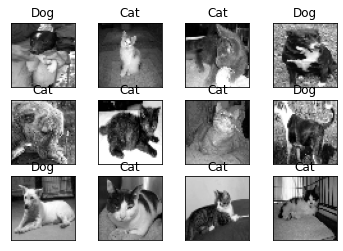

In [14]:
fig = plt.figure()
for num, data in enumerate(test_data[:12]):
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3, 4, num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label = 'Dog'
    else: str_label = 'Cat'
    
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.show()

In [15]:
with open('submission-file.csv', 'w') as f:
    f.write('id,label\n')

In [16]:
with open('submission-file.csv', 'a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
        
        model_out = model.predict([data])[0]
        
        f.write('{},{}\n'.format(img_num, model_out[1]))

100%|██████████| 12500/12500 [00:15<00:00, 822.40it/s]
